## Photometry With MCMC

Having gotten the target files in the previous notebook, I'm going to now use the file `corecomposition/photometry.py` to fetch more photometry from either DES or PANSTARRS. Then, I'll run MCMC with a much better constraint on the temperature which will also give me a better constraint on the radius. 

First, I'll read in the gold, silver, and bronze samples. The gold and silver samples are both subsets of the bronze sample, so I'll do all of the analysis on the bronze table (since that will also analyze the stars in the gold and silver samples). 

In [1]:
### general
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('stefan.mplstyle')

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join

### project-specific
import sys
sys.path.append('../')
sys.path.append('../../')
import corecomposition as cc
import WD_models

gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

The function `corecomposition/photometry.py:fetch_photometry()` uses `TAP` to query DES and PANSTARRS for extra photometry. I use DES's published conversion functions to turn their photometry into PANSTARRS bands, and prefer that over actual PANSTARRS photometry wherever possible. 

In [2]:
photo = cc.photometry.fetch_photometry(bronze['wd_source_id']) # fetch PANSTARRS and DES photometry for the source_ids in the sample
bronze = join(bronze, photo, keys_left='wd_source_id', keys_right='source_id') # join the two on the wd source_id

The photometry is processed in several steps:
1. The Gaia photometry is collected, and the G-band magnitude is corrected using Tyler's code.
2. Extra photometry is collected by querying DES and PANSTARRS, and that is added to the list of photometry.
3. The photometry is dereddened using the Edenhofer+2023 dustmap.
4. Tyler's code is used to fit teff and radius using the available bands with MCMC.

In the next two cells, I collect all the information that will be necessary to run the MCMC fit. I use the radius and teff fitted with least squares as the initial guess for MCMC to hopefully avoid false minima.

In [3]:
# information needed for MCMC fitting each target
source_ids = bronze['wd_source_id'] # array of source_ids
coords = [SkyCoord(frame="galactic", l=bronze['wd_l'][i]*u.deg, b=bronze['wd_b'][i]*u.deg, distance = bronze['r_med_geo'][i] * u.pc) for i in range(len(bronze))] # contains the locations of each target
astrometric_params = bronze['wd_astrometric_params_solved'] # used for correcting g-band in Tyler's code
photo = np.array([bronze['wd_phot_g_mean_mag'], bronze['wd_phot_bp_mean_mag'], bronze['wd_phot_rp_mean_mag']]).T # the basic Gaia photometry
e_photo = np.array([bronze['wd_e_gmag'], bronze['wd_e_bpmag'], bronze['wd_e_rpmag']]).T # Gaia photometry error
initial_params = np.array([[10000]*len(bronze), bronze['cmd_radius']]).T # initial guesses

Now, I can pass this information to the class `corecomposition/photometry.py:Photometry()` which will automatically collect the DES/PANSTARRS photometry, apply the G-band correction, apply dereddening to each band, and get everything in order to perform the MCMC fit.

In [4]:
obj = cc.photometry.Photometry(source_ids, coords, astrometric_params, photo, e_photo, initial_params)

100%|██████████| 30/30 [00:00<00:00, 174.26it/s]


In [5]:
# array([20.69774628, 20.85405159, 20.11615562, 21.40539932, 20.65850067, 20.30249977, 20.21529961, 20.07729912])

In [6]:
obj.bands[0]

array(['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z',
       'PS1_y'], dtype='<U7')

Running this many MCMC fits takes a while, so I save the chains in a dictionary whose keys are the Gaia source ids. I've pre-computed the CO core compositions, which I load in in the next cell. Because it takes so long to run, I've set the cells to `raw` so that they won't run by default. 

In [7]:
import corner

def plot_corner(chain):
    labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
    best_est = np.zeros((len(labels)))
    unc = []

    for i in range(len(labels)):
        mcmc = np.percentile(chain[:, i],[16,50,84])
        best_est[i] = mcmc[1]
        unc.append(np.diff(mcmc))
    unc = np.array(unc)

    emcee_plot = corner.corner(chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                            title_fmt = '.3f', title_kwargs={"fontsize": 12})
    plt.show()

In [8]:
with open('../data/cleaned/radius_chains_warwick_da.pkl', 'rb') as f:
    warwick_da_chains = pickle.load(f)

with open('../data/cleaned/radius_chains_CO_Hdef.pkl', 'rb') as f:
    co_hdef_chains = pickle.load(f)

with open('../data/cleaned/radius_chains_CO_Hrich.pkl', 'rb') as f:
    co_hrich_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hdef.pkl', 'rb') as f:
#    one_hdef_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hrich.pkl', 'rb') as f:
#    one_hrich_chains = pickle.load(f)

In [9]:
source_ids = obj.source_ids
radius_med = []
radius_low = []
radius_high = []

for wdid in source_ids:
    mcmc = np.percentile(warwick_da_chains[wdid][:,1],[16,50,84])
    unc = np.diff(mcmc)
    radius_med.append(mcmc[1])
    radius_low.append(unc[0])
    radius_high.append(unc[1])

radius_table = Table()
radius_table['wd_source_id'] = source_ids
radius_table['radius_med'] = radius_med
radius_table['radius_low'] = radius_low
radius_table['radius_high'] = radius_high

In [10]:
catalog = join(bronze, radius_table, keys='wd_source_id')
catalog['radius_sigma'] = (catalog['radius_med'] - catalog['cmd_radius'])
silver = np.isin(catalog['wd_source_id'], silver['wd_source_id'])
gold = np.isin(catalog['wd_source_id'], gold['wd_source_id'])

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_219833/3410762465.py:4: SyntaxWarning: invalid escape sequence '\o'
  ax1.set_ylabel('$R_{CMD}-R_{MCMC}$ [$R_\odot$]')


Text(0.5, 0, 'WD RUWE')

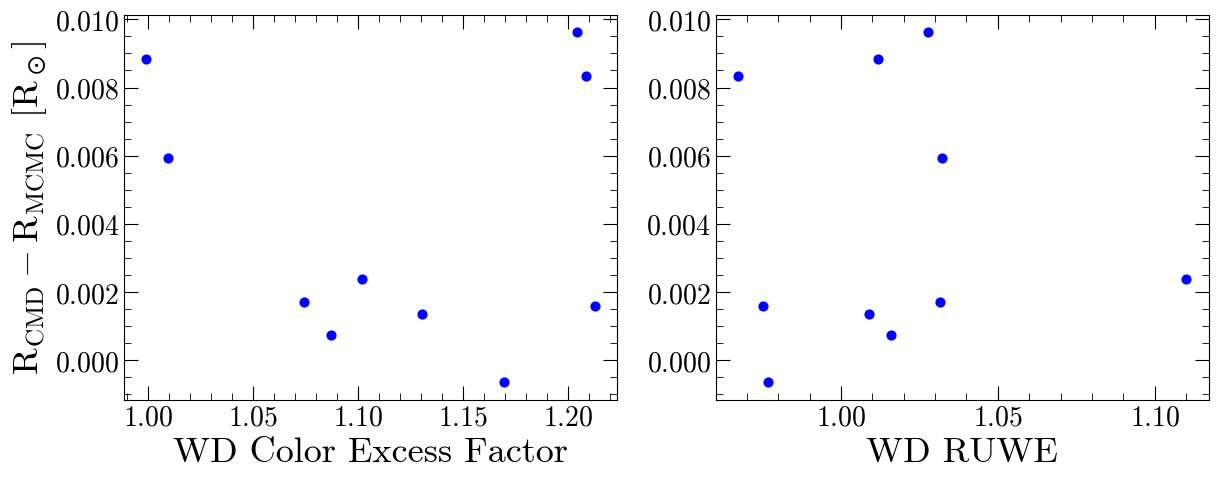

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
ax1.scatter(catalog[silver]['wd_phot_bp_rp_excess_factor'], catalog[silver]['radius_sigma'], s=40, c = 'blue')
ax1.set_xlabel('WD Color Excess Factor')
ax1.set_ylabel('$R_{CMD}-R_{MCMC}$ [$R_\odot$]')

ax2.scatter(catalog[silver]['wd_ruwe'], catalog[silver]['radius_sigma'], s=40, c = 'blue')
ax2.set_xlabel('WD RUWE')


In [12]:
import pyphot
filter_library = pyphot.get_library()

def make_ps1_cmd(catalog):
    g = catalog['PS1_g'].data
    r = catalog['PS1_r'].data
    lib = pyphot.get_library()
    filters = [lib['PS1_g'], lib['PS1_r'], lib['PS1_i'], lib['PS1_z'], lib['PS1_y']]
    vega_zeros = np.array([filt.Vega_zero_Jy.value for filt in filters])

    # converts to mag
    g_jy = vega_zeros[0] * 10**(g / -2.5)
    r_jy = vega_zeros[1] * 10**(r / -2.5)

    g_ab = - 2.5 * np.log10(g_jy * 1e-23) - 48.594
    r_ab = - 2.5 * np.log10(r_jy * 1e-23) - 48.594
    return (g_ab - r_ab).filled(-999), g_ab.filled(-999), r_ab.filled(-999), g_jy, r_jy

def logg_cmd_position(radarray, loggarray, lowmass = 'f', midmass = 'f', highmass = 'f', bands=('bp3-rp3', 'G3')):
    font_model = WD_models.load_model(lowmass, midmass, highmass, 'H', HR_bands = bands)
    rsun_logg_to_m = WD_models.interp_xy_z_func(x = font_model['color'], y = font_model['logg'],\
                                                z = font_model['Mag'], interp_type = 'linear')
    mass = rsun_logg_to_m(radarray, loggarray)
    return mass

colors = np.linspace(-0.5, 1, 100)
gaia_theoretical_rvs_7 = logg_cmd_position(colors, 7, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_7_5 = logg_cmd_position(colors, 7.5, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_8 = logg_cmd_position(colors, 8, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))
gaia_theoretical_rvs_9 = logg_cmd_position(colors, 9, 'f', 'f', 'f', bands=('bp3-rp3', 'G3'))

ps1_theoretical_rvs_7 = logg_cmd_position(colors, 7, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_7_5 = logg_cmd_position(colors, 7.5, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_8 = logg_cmd_position(colors, 8, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))
ps1_theoretical_rvs_9 = logg_cmd_position(colors, 9, 'f', 'f', 'f', bands=('Pg-Pr', 'Pr'))

/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


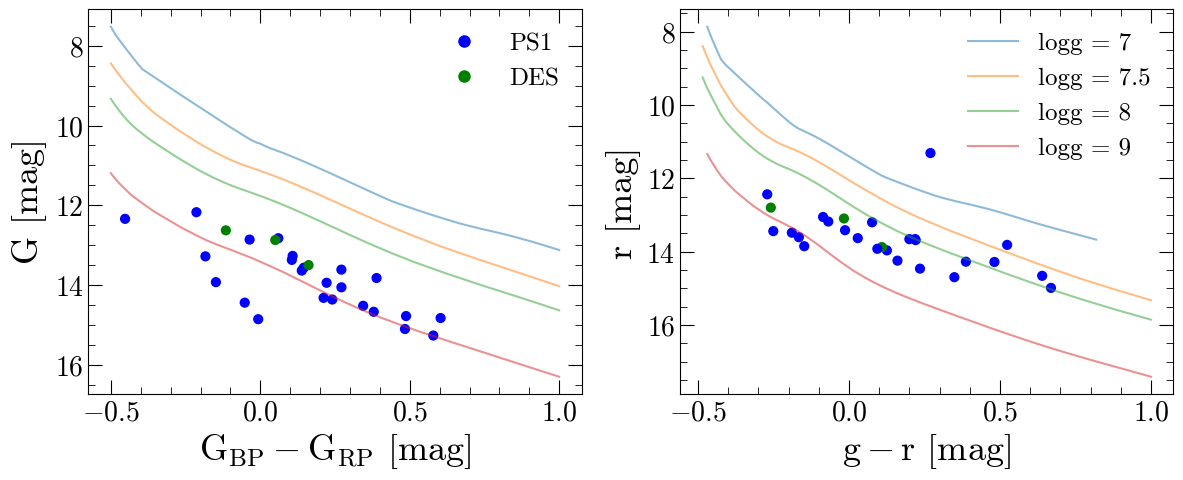

In [13]:
from matplotlib.lines import Line2D

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))

temp = np.all([catalog['PS1_r'] > -50, catalog['PS1_g'] > -50], axis = 0)
colors_mapping = {"des": "green", "ps1": "blue"}
source_colors = [colors_mapping.get(cat, "black") for cat in catalog[temp]['source']]

a = 0.5
ax1.plot(colors, gaia_theoretical_rvs_7, alpha = a)
ax1.plot(colors, gaia_theoretical_rvs_7_5, alpha = a)
ax1.plot(colors, gaia_theoretical_rvs_8, alpha = a)
ax1.plot(colors, gaia_theoretical_rvs_9, alpha = a)

scatter = ax1.scatter(catalog[temp]['bpmag_dereddened'] - catalog[temp]['rpmag_dereddened'], catalog[temp]['wd_m_g'], s = 40, c = source_colors, label=colors_mapping)
ax1.invert_yaxis()
ax1.set_xlabel('$G_{BP}-G_{RP}$ [mag]')
ax1.set_ylabel('$G$ [mag]')
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='PS1', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='DES', markerfacecolor='green', markersize=10)
]
ax1.legend(handles=legend_elements, framealpha=0)

ax2.plot(colors, ps1_theoretical_rvs_7, alpha = a, label = 'logg = 7')
ax2.plot(colors, ps1_theoretical_rvs_7_5, alpha = a, label = 'logg = 7.5')
ax2.plot(colors, ps1_theoretical_rvs_8, alpha = a, label = 'logg = 8')
ax2.plot(colors, ps1_theoretical_rvs_9, alpha = a, label = 'logg = 9')

g_r, g, r, g_jy, r_jy = make_ps1_cmd(catalog)

ax2.scatter(g_r[temp], r[temp] - 5 * (np.log10(catalog[temp]['r_med_geo']) - 1), s = 40, c = source_colors)
ax2.invert_yaxis()
ax2.set_xlabel('$g - r$ [mag]')
ax2.set_ylabel('r [mag]')
ax2.legend(framealpha=0)


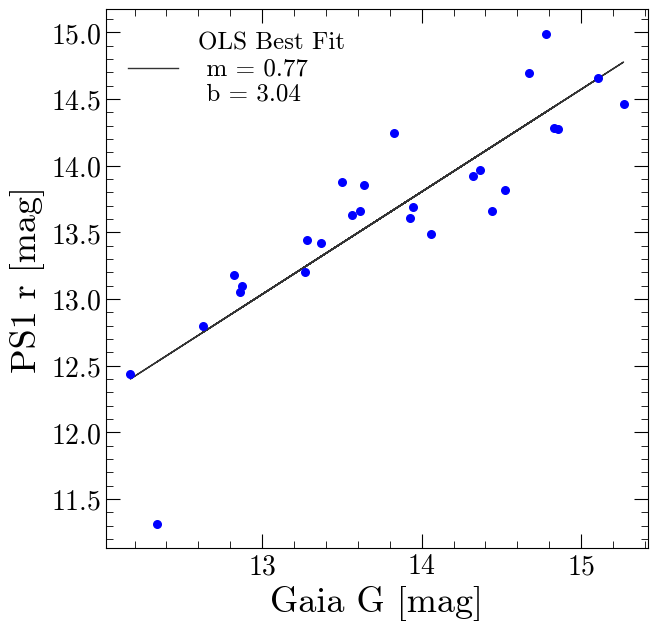

In [14]:
x = catalog[temp]['wd_m_g']
y = r[temp] - 5 * (np.log10(catalog[temp]['r_med_geo']) - 1)
m, b = np.polyfit(x, y, 1)

plt.scatter(x, y, s = 30, c = 'blue')
plt.plot(x, m*x+b, c = 'k', alpha = 0.8, zorder = 0, lw = 1, label = f'OLS Best Fit\n m = {m:2.2f}\n b = {b:2.2f}')
plt.xlabel('Gaia G [mag]')
plt.ylabel('PS1 r [mag]')
plt.legend(framealpha=0)

In [15]:
i = 1
catalog['wd_source_id'][i], g_r[i], r[i] - 5 * (np.log10(catalog[temp]['r_med_geo'][i]) - 1)

(1424062412046712576, -0.06880188, 13.18016994450308)

In [16]:
catalog[['wd_source_id', 'wd_phot_g_mean_mag']].pprint(100,100)

    wd_source_id    wd_phot_g_mean_mag
------------------- ------------------
1307515077152381568 20.463973999023438
1424062412046712576  19.94845962524414
1505061200282617728 20.443767547607422
1699104219238181248 20.058536529541016
1792836069385045760 19.998979568481445
1889409474189137152 20.545780181884766
1895697134508504704  20.51539421081543
2084572311384460672 20.129125595092773
2153552814748001792 19.824588775634766
2577004017102144256 20.096324920654297
2603365323772560768  20.41132354736328
2690318895188779136 20.112577438354492
2809172631816775168  20.11560821533203
2908617170714127104  19.94867515563965
3090038517737811712 19.467735290527344
3121385658671190784 17.237316131591797
3249027001465705088 18.224544525146484
3267693925768589696 20.438705444335938
3305291519719761280 20.463254928588867
3639268180952016768 20.276857376098633
3932749274881864320 20.098825454711914
4033508722314651392 20.725482940673828
4248619071266347648 19.120485305786133
4595031204703995136  20.2

## Radius Debugging

In [20]:
i = 1
wd_id = catalog['wd_source_id'][i]

j = np.where(obj.source_ids == wd_id)[0][0]

In [21]:
catalog[i]

wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2

In [26]:
import sys
sys.path.append('../')
from corecomposition import interpolator
import corner
from tqdm import tqdm

gaia_chains = {}
base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

for j in tqdm(range(len(obj.source_ids))):
    source_id = obj.source_ids[j]
    distance = obj.geometry[j].distance.value
    bands = obj.bands[j]
    photomet = obj.photometry[j]
    e_photomet = obj.e_photometry[j]
    initial_guess = obj.initial_guess[j]

    gaia_model = interpolator.WarwickDAInterpolator(bands[0:3])
    # run the MCMC fit using one of the interpolators
    gaia_engine = interpolator.MCMCEngine(gaia_model)
    gaia_flat_chain = gaia_engine.run_mcmc(photomet[0:3], e_photomet[0:3], distance, initial_guess)
    gaia_chains[source_id] = gaia_flat_chain

  0%|          | 0/30 [00:00<?, ?it/s]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [280.69710617 279.12838911]


Auto-Correlation Time = 280.69710617239923, additional steps = 12096


  3%|▎         | 1/30 [01:53<54:57, 113.72s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [208.97746297 203.52855136]


Auto-Correlation Time = 208.97746296718427, additional steps = 8366


  7%|▋         | 2/30 [03:13<43:37, 93.49s/it] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [202.54931703 204.63988663]


Auto-Correlation Time = 204.63988663358361, additional steps = 8141


 10%|█         | 3/30 [04:37<40:16, 89.51s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [251.20726334 254.34992466]


Auto-Correlation Time = 254.34992465593356, additional steps = 10726


 13%|█▎        | 4/30 [06:23<41:35, 95.98s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [258.65827194 256.70871124]


Auto-Correlation Time = 258.6582719374702, additional steps = 10950


 17%|█▋        | 5/30 [08:03<40:34, 97.37s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [265.47732012 262.1933975 ]


Auto-Correlation Time = 265.47732011800946, additional steps = 11304


 20%|██        | 6/30 [09:45<39:32, 98.84s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [244.94624588 234.77201954]


Auto-Correlation Time = 244.9462458825824, additional steps = 10237


 23%|██▎       | 7/30 [11:15<36:45, 95.87s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [209.16965323 213.5912413 ]


Auto-Correlation Time = 213.59124130053664, additional steps = 8606


 27%|██▋       | 8/30 [12:38<33:44, 92.03s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [190.28592349 190.92300617]


Auto-Correlation Time = 190.9230061748437, additional steps = 7427


 30%|███       | 9/30 [13:51<30:02, 85.85s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [220.85663313 220.4270076 ]


Auto-Correlation Time = 220.85663312841186, additional steps = 8984


 33%|███▎      | 10/30 [15:29<29:56, 89.83s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [202.9978256  200.27319237]


Auto-Correlation Time = 202.99782560330286, additional steps = 8055


 37%|███▋      | 11/30 [16:48<27:19, 86.27s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [280.72583549 280.1962901 ]


Auto-Correlation Time = 280.72583549104746, additional steps = 12097


 40%|████      | 12/30 [18:43<28:30, 95.02s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [234.29183714 237.27783058]


Auto-Correlation Time = 237.27783058312545, additional steps = 9838


 43%|████▎     | 13/30 [20:19<27:05, 95.60s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [239.2603894  236.75322491]


Auto-Correlation Time = 239.2603894003258, additional steps = 9941


 47%|████▋     | 14/30 [22:06<26:22, 98.90s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [242.43843457 253.64603956]


Auto-Correlation Time = 253.64603956272282, additional steps = 10689


 50%|█████     | 15/30 [23:49<25:01, 100.09s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [168.07619285 153.45436799]


Auto-Correlation Time = 168.0761928520001, additional steps = 6239


 53%|█████▎    | 16/30 [25:03<21:30, 92.15s/it] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [142.98329099 130.60614877]


Auto-Correlation Time = 142.98329099333077, additional steps = 4935


 57%|█████▋    | 17/30 [26:06<18:04, 83.39s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [233.3417996  230.52304682]


Auto-Correlation Time = 233.34179960330928, additional steps = 9633


 60%|██████    | 18/30 [27:39<17:15, 86.32s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [228.06335652 225.22299194]


Auto-Correlation Time = 228.0633565249875, additional steps = 9359


 63%|██████▎   | 19/30 [29:13<16:14, 88.63s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [239.12934247 245.57525828]


Auto-Correlation Time = 245.57525828400625, additional steps = 10269


 67%|██████▋   | 20/30 [30:46<15:01, 90.12s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [257.53848876 256.87733907]


Auto-Correlation Time = 257.5384887579736, additional steps = 10892


 70%|███████   | 21/30 [32:23<13:49, 92.20s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [254.61283522 262.94818082]


Auto-Correlation Time = 262.9481808173152, additional steps = 11173


 73%|███████▎  | 22/30 [34:07<12:45, 95.68s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [190.11588217 189.43336088]


Auto-Correlation Time = 190.11588216782977, additional steps = 7386


 77%|███████▋  | 23/30 [35:28<10:38, 91.19s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [227.63289991 236.41849336]


Auto-Correlation Time = 236.41849335654854, additional steps = 9793


 80%|████████  | 24/30 [37:23<09:50, 98.40s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [223.99951388 203.55668152]


Auto-Correlation Time = 223.9995138841094, additional steps = 9147


 83%|████████▎ | 25/30 [39:07<08:20, 100.15s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [201.40372215 200.36331073]


Auto-Correlation Time = 201.40372215465536, additional steps = 7972


 87%|████████▋ | 26/30 [40:30<06:19, 94.99s/it] The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [262.51160926 261.80621132]


Auto-Correlation Time = 262.511609262253, additional steps = 11150


 90%|█████████ | 27/30 [42:17<04:55, 98.43s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [249.19558267 248.05543155]


Auto-Correlation Time = 249.19558267088055, additional steps = 10458


 93%|█████████▎| 28/30 [44:05<03:22, 101.40s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [262.75315472 260.5787355 ]


Auto-Correlation Time = 262.75315472441105, additional steps = 11163


 97%|█████████▋| 29/30 [45:46<01:41, 101.27s/it]The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [261.5878752  283.67621214]


Auto-Correlation Time = 283.67621213597255, additional steps = 12251


100%|██████████| 30/30 [47:40<00:00, 95.35s/it] 


In [27]:
with open('../data/cleaned/radius_chains_warwick_gaia.pkl', 'wb') as f:
    pickle.dump(gaia_chains, f)

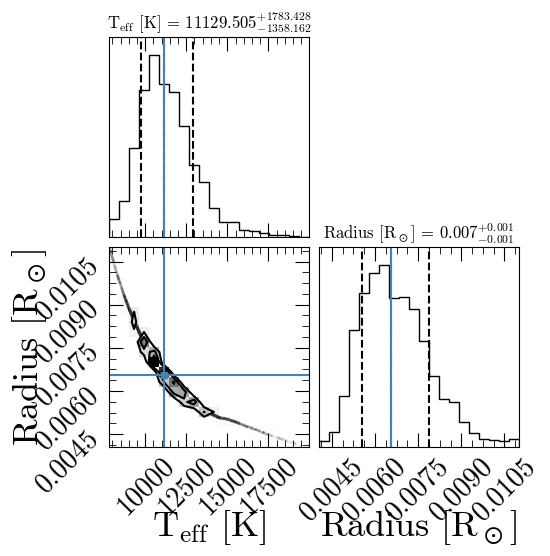

In [37]:
source = list(gaia_chains.keys())[9]
labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(gaia_chains[source][:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(gaia_chains[source], labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

In [64]:
best_est = np.zeros((len(labels)))
radius = []
unc = []

for source in gaia_chains.keys():
    mcmc = np.percentile(gaia_chains[source][:, 1],[16,50,84])
    radius.append(mcmc[1])
    unc.append(np.diff(mcmc))
radius = np.array(radius)
unc = np.sum(np.array(unc), axis=1)

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_219833/2789288126.py:4: SyntaxWarning: invalid escape sequence '\o'
  ax1.set_xlabel('Radius $[R_\odot]$')
/tmp/ipykernel_219833/2789288126.py:7: SyntaxWarning: invalid escape sequence '\o'
  ax2.set_xlabel('Radius Uncertainty $[R_\odot]$')


Text(0, 0.5, 'Count')

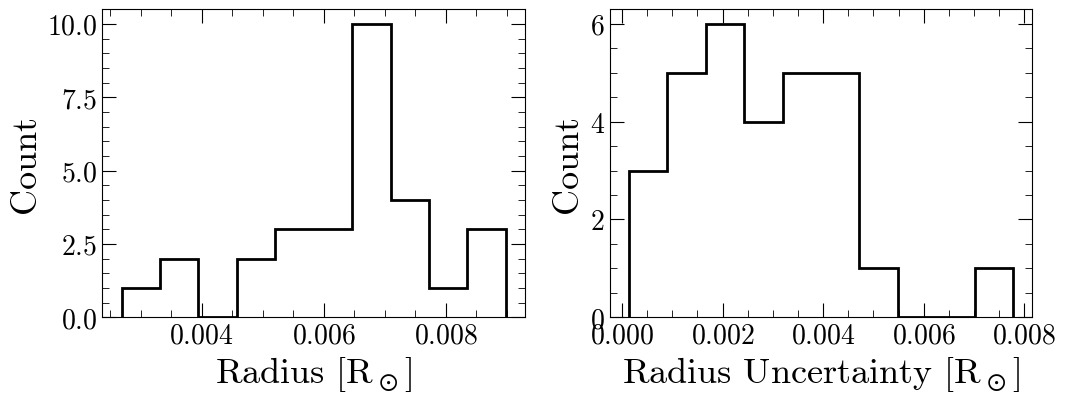

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(12, 4))
mask = np.all([radius < 0.01], axis = 0)
ax1.hist(radius[mask], bins = 10, histtype='step', color = 'k', lw=2)
ax1.set_xlabel('Radius $[R_\odot]$')
ax1.set_ylabel('Count')
ax2.hist(unc, bins = 10, histtype='step', color = 'k', lw=2)
ax2.set_xlabel('Radius Uncertainty $[R_\odot]$')
ax2.set_ylabel('Count')

(0.0, 1e-16)

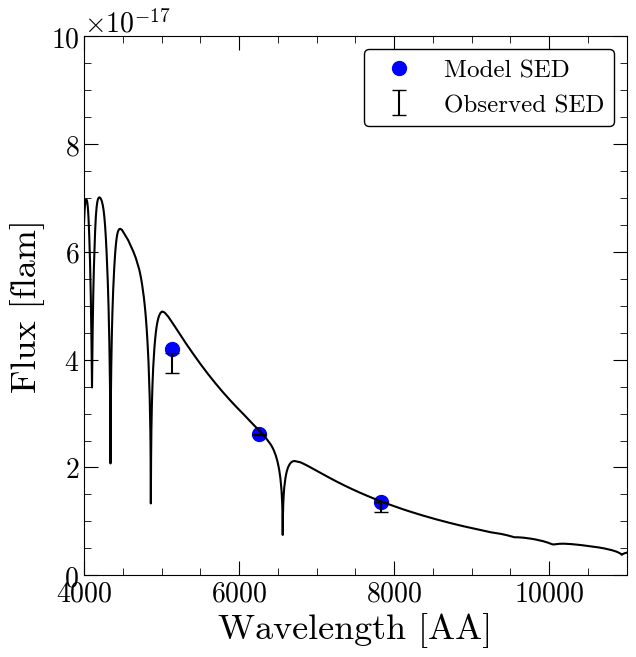

In [68]:
import pyphot
lib = pyphot.get_library()

model_flux = gaia_engine.get_model_flux(best_est, distance = distance)
flux, e_flux = gaia_engine.mag_to_flux(photomet[0:3], e_photomet[0:3])
wave = [lib[band].lpivot.to('angstrom').value for band in gaia_engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED', zorder=100)
plt.plot(wave, model_flux, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')
plt.xlabel(r'Wavelength [AA]')
plt.ylabel(r'Flux [flam]')
plt.legend()
plt.xlim(4000, 11000)
plt.ylim(0, 1e-16)

['PS1_g' 'PS1_r' 'PS1_i' 'PS1_z']
Auto-Correlation Time = 32.30417742070846, additional steps = -821


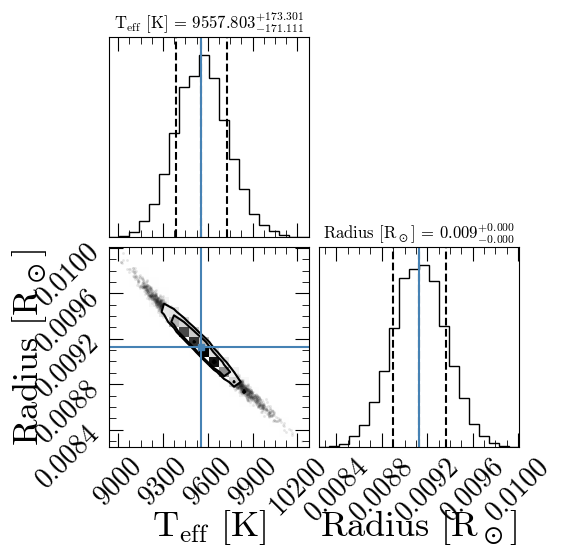

In [69]:
print(bands[3:-1])

#panstarrs_model = interpolator.LaPlataUltramassive(bands[3:], core = 'CO', layer = 'Hrich')
panstarrs_model = interpolator.WarwickDAInterpolator(bands[3:-1])
# run the MCMC fit using one of the interpolators
panstarrs_engine = interpolator.MCMCEngine(panstarrs_model)
panstarrs_flat_chain = panstarrs_engine.run_mcmc(photomet[3:-1], e_photomet[3:-1], distance, initial_guess)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(panstarrs_flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(panstarrs_flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

In [70]:
bands

array(['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z',
       'PS1_y'], dtype='<U7')

(4000.0, 11000.0)

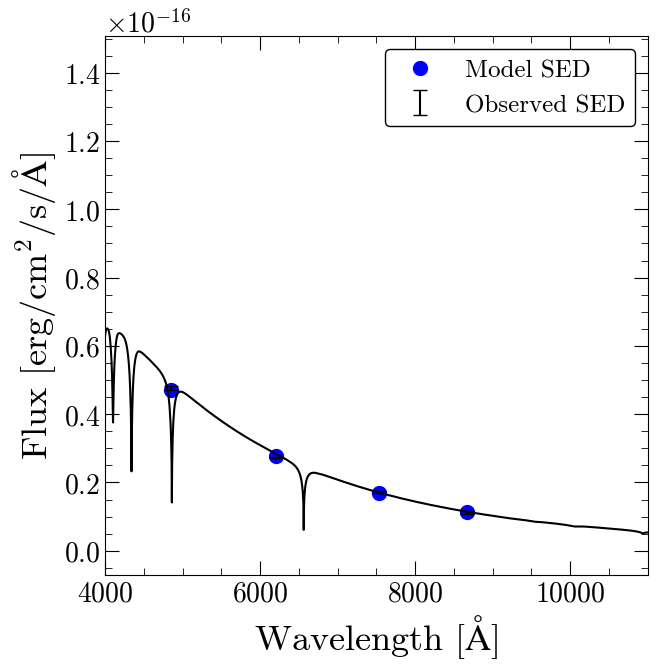

In [71]:
model_flux = panstarrs_engine.get_model_flux(best_est, distance = distance)
flux, e_flux = panstarrs_engine.mag_to_flux(photomet[3:-1], e_photomet[3:-1])
wave = [lib[band].lpivot.to('angstrom').value for band in panstarrs_engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED', zorder=100)
plt.plot(wave, model_flux, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [erg/cm$^2$/s/$\AA$]')
plt.legend()
plt.xlim(4000, 11000)

['Gaia_G' 'Gaia_BP' 'Gaia_RP' 'PS1_g' 'PS1_r' 'PS1_i' 'PS1_z']
Auto-Correlation Time = 37.44335147011149, additional steps = -553


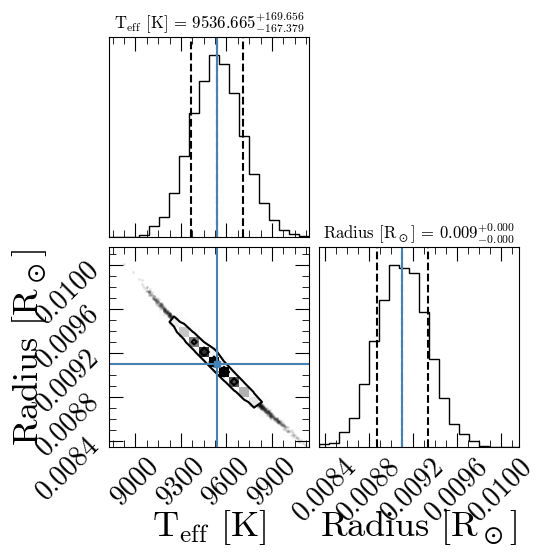

In [72]:
print(bands[:-1])
co_hrich_model = interpolator.WarwickDAInterpolator(bands[:-1])
# run the MCMC fit using one of the interpolators
engine = interpolator.MCMCEngine(co_hrich_model)
flat_chain = engine.run_mcmc(photomet[:-1], e_photomet[:-1], distance, initial_guess)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_44653/1250653165.py:10: SyntaxWarning: invalid escape sequence '\o'
  capsize = 5, label = f'Observed SED\nInterp R = {catalog[gold]['cmd_radius'][i]:2.3f} $R_\odot$\nMCMC R = {best_est[1]:2.3f} $R_\odot$', zorder=100)
/tmp/ipykernel_44653/1250653165.py:10: SyntaxWarning: invalid escape sequence '\o'
  capsize = 5, label = f'Observed SED\nInterp R = {catalog[gold]['cmd_radius'][i]:2.3f} $R_\odot$\nMCMC R = {best_est[1]:2.3f} $R_\odot$', zorder=100)


(4000.0, 11000.0)

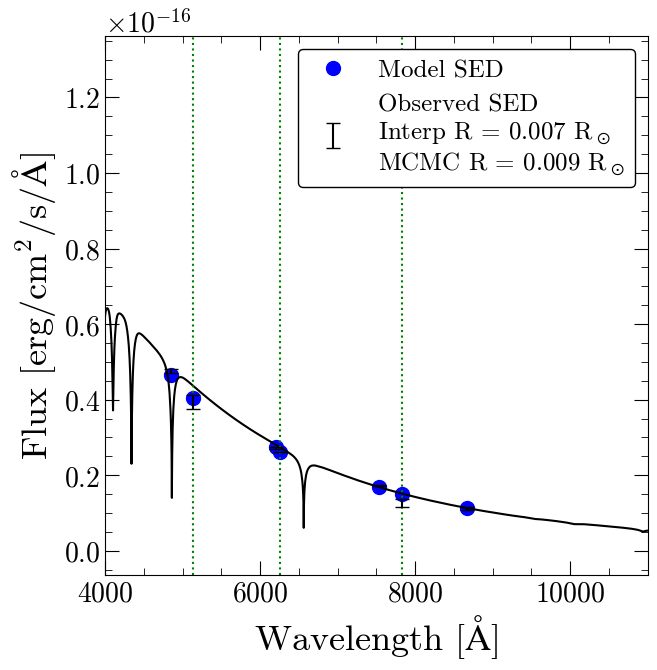

In [73]:
first_est = [9362, 0.009]

model_flux_best = engine.get_model_flux(best_est, distance = distance)
#model_flux_first = engine.get_model_flux(first_est, distance = distance)

flux, e_flux = engine.mag_to_flux(photomet, e_photomet)
wave = [lib[band].lpivot.to('angstrom').value for band in engine.bands]

plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = f'Observed SED\nInterp R = {catalog[gold]['cmd_radius'][i]:2.3f} $R_\odot$\nMCMC R = {best_est[1]:2.3f} $R_\odot$', zorder=100)
plt.plot(wave, model_flux_best, 'bo', markersize = 10, label = 'Model SED')
plt.plot(base_wavl, build_spec(best_est, distance), c='k')

for i in range(3):
    plt.axvline(wave[i], c = 'green', ls = ':')

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [erg/cm$^2$/s/$\AA$]')
plt.legend()
plt.xlim(4000, 11000)

In [74]:
source_ids

1424062412046712576

In [75]:
bronze[bronze['wd_source_id'] == source_ids][['ms_source_id', 'wd_ra', 'wd_dec']]

ms_source_id,wd_ra,wd_dec
int64,float64,float64
1424062622501321984,246.3559278753405,51.172309493391886


In [76]:
catalog[gold][['wd_source_id', 'cmd_radius', 'radius_med']]

wd_source_id,cmd_radius,radius_med
int64,float64,float64
2153552814748001792,0.0067775427053977004,0.00917106618684483
3249027001465705088,0.007198684270318171,0.007948928631084068
4248619071266347648,0.007001884607420573,0.008370611192363032


In [77]:
elbadry = Table.read('../data/raw/elbadry.csv')



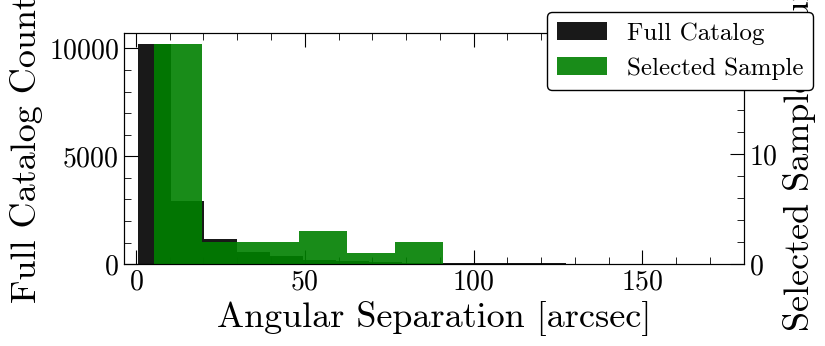

In [78]:
fig, ax1 = plt.subplots(figsize=(8,3))
ax1.set_xlim(-0.001*3600, 0.05*3600)
ax1.set_xlabel(r'Angular Separation [arcsec]')
ax2 = ax1.twinx()

ax2.hist(bronze['pairdistance']*3600, zorder = 1, color = 'green', alpha = 0.9, label = 'Selected Sample')
ax2.set_ylabel('Selected Sample Count')
ax1.hist(elbadry['pairdistance']*3600, bins = 100, alpha = 0.9, label = 'Full Catalog', color = 'k', zorder = 0);
ax1.set_ylabel('Full Catalog Count')

fig.legend()
